# RNA Multi-Perceptrón Backpropagation para procesar las imágenes e identificar si es auto, moto ó camión.

## Cargar librerías:

In [2]:
!sudo apt install subversion

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 29 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import keras
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.utils import plot_model

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import sys
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
  print('Running on Google Colab')

print("Librerías cargadas")

Using TensorFlow backend.


Running on Google Colab
Librerías cargadas


## Definir los parámetros:

In [18]:
# tamaño de las imágenes
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 1)

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]


# define tamaño de datos de salida (las clases están codificadas en un único número)
num_outputs = 1 

# cantidad de neuronas ocultas 
hidden_layers_neuron_counts = [ 784, 392, 56, 32 ] 

# cantidad de épocas del entrenamiento
epochs_count = 10

print("Configuración de RNA MLP Backpropagation definida: [", num_inputs, hidden_layers_neuron_counts, num_outputs," ] ")

Configuración de RNA MLP Backpropagation definida: [ 1024 [784, 392, 56, 32] 1  ] 


### Algunas otras burocracias..

In [7]:
if IS_COLAB:
    DATASET_PATH = '/content/datasets'
else:
    DATASET_PATH = './datasets'

IMAGE_CLASSES = ['car', 'motorcycle', 'truck']
RAW_PATH = os.path.join(DATASET_PATH, 'raw')
MINIFIED_PATH = os.path.join(DATASET_PATH, 'minified')

os.makedirs(RAW_PATH)
os.makedirs(MINIFIED_PATH)

print('Done!')

Done!


## Descarga las imagenes de drive, si se está corriendo en colab
> Este paso se puede saltear y usar las imagenes preprocesadas que están en el repo de Github

In [28]:
! cd datasets && svn checkout https://github.com/mnmallea/vehicles-images-detector/trunk/datasets/raw

A    raw/car
A    raw/car/00004.jpg
A    raw/car/00022.jpg
A    raw/car/00062.jpg
A    raw/car/00064.jpg
A    raw/car/00076.jpg
A    raw/car/00093.jpg
A    raw/car/00128.jpg
A    raw/car/00130.jpg
A    raw/car/00166.jpg
A    raw/car/00169.jpg
A    raw/car/00173.jpg
A    raw/car/00257.jpg
A    raw/car/00266.jpg
A    raw/car/00301.jpg
A    raw/car/00315.jpg
A    raw/car/00404.jpg
A    raw/car/00468.jpg
A    raw/car/00472.jpg
A    raw/car/00475.jpg
A    raw/car/00501.jpg
A    raw/car/00504.jpg
A    raw/car/00523.jpg
A    raw/car/00531.jpg
A    raw/car/00644.jpg
A    raw/car/00645.jpg
A    raw/car/00652.jpg
A    raw/car/00670.jpg
A    raw/car/00677.jpg
A    raw/car/00691.jpg
A    raw/car/00694.jpg
A    raw/car/00748.jpg
A    raw/car/00785.jpg
A    raw/car/00832.jpg
A    raw/car/00834.jpg
A    raw/car/00847.jpg
A    raw/car/00854.jpg
A    raw/car/00855.jpg
A    raw/car/00858.jpg
A    raw/car/00862.jpg
A    raw/car/00896.jpg
A    raw/car/00900.jpg
A    raw/car/00923.jpg
A    raw/car/00936.jp

## Preprocesamiento de imágenes
Las imágenes se achican a un tamaño de 32x32 y se convierten a escala de grises.

In [0]:
def minimized_image(image):
    return image.convert('L').resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.ANTIALIAS)

def minify_image_from_class(from_directory, to_directory):
    for root, dirs, files in os.walk(from_directory):
        for image_name in files:
            image_path = os.path.join(root, image_name)
            image = Image.open(image_path)
            image = minimized_image(image)
            image.save(os.path.join(to_directory, image_name))

for image_class in IMAGE_CLASSES:
    input_dir = os.path.join(RAW_PATH, image_class)
    output_dir = os.path.join(MINIFIED_PATH, image_class)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    minify_image_from_class(input_dir, output_dir)

print('Done')


Done


> Se pueden descargar las imagenes minimizadas de github para evitar descargar archivos grandes


In [12]:
! cd datasets && svn checkout https://github.com/mnmallea/vehicles-images-detector/trunk/datasets/minified

A    minified/car
A    minified/car/00004.jpg
A    minified/car/00022.jpg
A    minified/car/00062.jpg
A    minified/car/00064.jpg
A    minified/car/00076.jpg
A    minified/car/00093.jpg
A    minified/car/00128.jpg
A    minified/car/00130.jpg
A    minified/car/00166.jpg
A    minified/car/00169.jpg
A    minified/car/00173.jpg
A    minified/car/00257.jpg
A    minified/car/00266.jpg
A    minified/car/00301.jpg
A    minified/car/00315.jpg
A    minified/car/00404.jpg
A    minified/car/00468.jpg
A    minified/car/00472.jpg
A    minified/car/00475.jpg
A    minified/car/00501.jpg
A    minified/car/00504.jpg
A    minified/car/00523.jpg
A    minified/car/00531.jpg
A    minified/car/00644.jpg
A    minified/car/00645.jpg
A    minified/car/00652.jpg
A    minified/car/00670.jpg
A    minified/car/00677.jpg
A    minified/car/00691.jpg
A    minified/car/00694.jpg
A    minified/car/00748.jpg
A    minified/car/00785.jpg
A    minified/car/00832.jpg
A    minified/car/00834.jpg
A    minified/car/00847.jpg
A 

In [13]:
import math
import re
import sys
import shutil

DISTRIBUTED_PATH = os.path.join(DATASET_PATH, 'distributed')
#Train and Test Set Variables
train_val_test_ratio = (.7,.1,.2) # 70/10/20 Data Split
test_folder = os.path.join(DISTRIBUTED_PATH, 'test')
train_folder = os.path.join(DISTRIBUTED_PATH, 'train')
val_folder = os.path.join(DISTRIBUTED_PATH, 'val')

#Remove Existing Folders if they exist
for folder in [test_folder, train_folder, val_folder]:
    if os.path.exists(folder) and os.path.isdir(folder):
        shutil.rmtree(folder)

#Remake Category Folders in both Train and Test Folders
for category in IMAGE_CLASSES:
    os.makedirs(os.path.join(test_folder, category))
    os.makedirs(os.path.join(train_folder, category))
    os.makedirs(os.path.join(val_folder, category))

#Split Data by Train Ratio and copy files to correct directory
for idx, category in enumerate(IMAGE_CLASSES):
    file_list = os.listdir(os.path.join(MINIFIED_PATH, category))
    
    train_ratio = math.floor(len(file_list) * train_val_test_ratio[0])
    val_ratio = math.floor(len(file_list) * train_val_test_ratio[1])
    train_list = file_list[:train_ratio]
    val_list = file_list[train_ratio:train_ratio + val_ratio]
    test_list = file_list[train_ratio + val_ratio:]
    
    for i, file in enumerate(train_list):
        shutil.copy(os.path.join(MINIFIED_PATH, category, file), os.path.join(train_folder, category, file))
    sys.stdout.write('Moving %s train images to category folder %s' % (len(train_list), category))  
    sys.stdout.write('\n')
    for i, file in enumerate(val_list):
        shutil.copy(os.path.join(MINIFIED_PATH, category, file), os.path.join(val_folder, category, file))
    sys.stdout.write('Moving %s validation images to category folder %s' % (len(val_list), category))                   
    sys.stdout.write('\n')
    for i, file in enumerate(test_list):
        shutil.copy(os.path.join(MINIFIED_PATH, category, file), os.path.join(test_folder, category, file))
    sys.stdout.write('Moving %s test images to category folder %s' % (len(test_list), category))
    sys.stdout.write('\n\n')
    
print("Done.")  

Moving 322 train images to category folder car
Moving 46 validation images to category folder car
Moving 93 test images to category folder car

Moving 200 train images to category folder motorcycle
Moving 28 validation images to category folder motorcycle
Moving 58 test images to category folder motorcycle

Moving 436 train images to category folder truck
Moving 62 validation images to category folder truck
Moving 125 test images to category folder truck

Done.


## Carga de imágenes

In [0]:
# Loads images and labels into numpy arrays
def load_img_directory(dir_path):
  classes = []
  images = []
  for class_name in os.listdir(dir_path):
    for image_name in os.listdir(os.path.join(dir_path, class_name)):          
          image = Image.open(os.path.join(dir_path, class_name, image_name))
          images.append(np.array(image))
          classes.append(class_name)
  return (images, classes)

In [15]:
# cargar las imágenes

(x_train, y_train) = load_img_directory(train_folder)
(x_val, y_val) = load_img_directory(val_folder)
(x_test, y_test) = load_img_directory(test_folder)

print('Dataset de train')
print("- Clases cargadas: ", len(set(y_train)))
print("- Imágenes cargadas: ", len(x_train))
print('')

print('Dataset de validación')
print("- Clases cargadas validación: ", len(set(y_val)))
print("- Imágenes cargadas validación: ", len(x_val))
print('')

print('Dataset de test')
print("- Clases cargadas test: ", len(set(y_test)))
print("- Imágenes cargadas test: ", len(x_test))
print('')

Dataset de train
- Clases cargadas:  3
- Imágenes cargadas:  958

Dataset de validación
- Clases cargadas validación:  3
- Imágenes cargadas validación:  136

Dataset de test
- Clases cargadas test:  3
- Imágenes cargadas test:  276



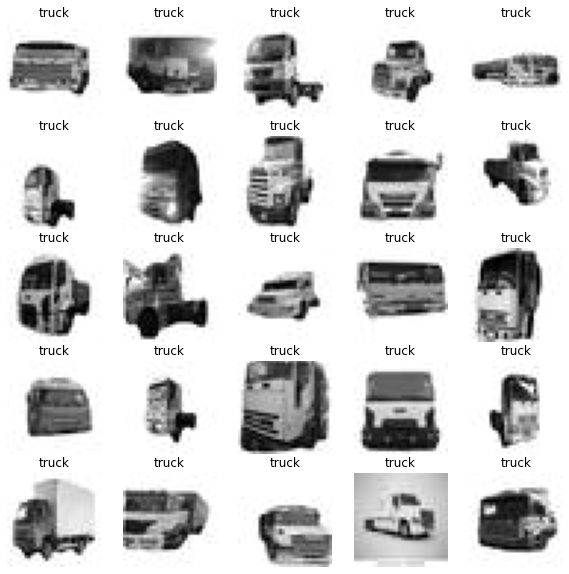

In [16]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.title(label_batch[n])
      plt.imshow(image_batch[n])
      plt.gray()
      plt.axis('off')

show_batch(x_train, y_train)

['car', 'motorcycle', 'truck']
{'car': 0, 'motorcycle': 1, 'truck': 2}
x_train (cant ejemplos, datos entrada):  (958, 1024)
y_train (cant):  958

Imagen reconstruida de  truck


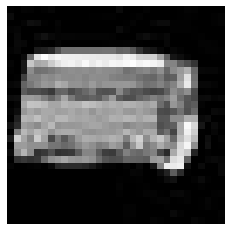

In [19]:
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def process_images_array(images):    
  images = np.array(images).astype('float32') / 255.
  return images.reshape((len(images), num_inputs))

def process_classes_array(classes):
  mapped = []
  for klass in classes:
    mapped.append(IMAGE_CLASSES_MAP[klass])
  return mapped

# define vector auxiliar de datos de entrada para usar en el entrenamiento
_x_train = process_images_array(x_train)
_x_test = process_images_array(x_test)
_x_val = process_images_array(x_val)

# define vector auxiliar de datos de salida para usar en el entrenamiento
# también usa esta información para determinar la cantida de neuronas de salida
print(IMAGE_CLASSES)
IMAGE_CLASSES_MAP = dict(zip(IMAGE_CLASSES, range(len(IMAGE_CLASSES))))
print(IMAGE_CLASSES_MAP)

_y_train = process_classes_array(y_train)
_y_test = process_classes_array(y_test)
_y_val = process_classes_array(y_val)

print("x_train (cant ejemplos, datos entrada): ", _x_train.shape)
print("y_train (cant): ", len(y_train))
print("\nImagen reconstruida de ", y_train[0])

plot_image(x_train[0])

## Definiendo el modelo

In [0]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model Helper function
def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               803600    
_________________________________________________________________
dense_2 (Dense)              (None, 392)               307720    
_________________________________________________________________
dense_3 (Dense)              (None, 56)                22008     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1824      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 1,135,185
Trainable params: 1,135,185
Non-trainable params: 0
_________________________________________________

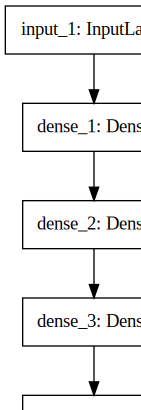

In [21]:
import functools
import pydot

input_layer = Input(shape=(IMAGE_HEIGHT * IMAGE_WIDTH,))

hidden_layers = functools.reduce(   lambda previous_layer, neurons_count: Dense(neurons_count, activation="relu")(previous_layer),
                                    hidden_layers_neuron_counts,
                                    input_layer)

output_layer = Dense(num_outputs, activation=None, name='output')(hidden_layers)

model = Model(input_layer, output_layer)
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

model.summary()
visualize_model(model)

## Entrenar el modelo:

In [22]:
# lleva a cabo el entrenamiento
model.fit(_x_train, _y_train, epochs = epochs_count, batch_size = 5, validation_data=(_x_val, _y_val))

Train on 958 samples, validate on 136 samples
Epoch 1/10
958/958 [==============================] - 2s 2ms/step - loss: 2.0773 - accuracy: 0.2902 - val_loss: 0.7359 - val_accuracy: 0.2426
Epoch 2/10
958/958 [==============================] - 2s 2ms/step - loss: 0.6842 - accuracy: 0.3570 - val_loss: 0.7346 - val_accuracy: 0.6029
Epoch 3/10
958/958 [==============================] - 2s 2ms/step - loss: 0.6605 - accuracy: 0.3904 - val_loss: 0.5962 - val_accuracy: 0.2941
Epoch 4/10
958/958 [==============================] - 2s 2ms/step - loss: 0.6060 - accuracy: 0.4040 - val_loss: 0.5787 - val_accuracy: 0.3456
Epoch 5/10
958/958 [==============================] - 2s 2ms/step - loss: 0.5969 - accuracy: 0.4603 - val_loss: 0.5714 - val_accuracy: 0.4044
Epoch 6/10
958/958 [==============================] - 2s 2ms/step - loss: 0.5689 - accuracy: 0.4395 - val_loss: 0.5187 - val_accuracy: 0.4191
Epoch 7/10
958/958 [==============================] - 2s 2ms/step - loss: 0.5591 - accuracy: 0.4823 - 

## Evaluación del modelo entrenado:

In [23]:
 # evalua al modelo entrenado
loss, accuracy = model.evaluate(_x_test, _y_test)
print("\n> Evaluación del Modelo: ")
print("    - Error: ", loss * 100, "%")
print("    - Exactitud: ", accuracy * 100,"%")
print("\n")


276/276 [==============================] - 0s 124us/step

> Evaluación del Modelo: 
    - Error:  50.54712813833485 %
    - Exactitud:  57.60869383811951 %




### Prediciendo una imágen de prueba random

Categories:  {0: 'car', 1: 'motorcycle', 2: 'truck'} 

Raw prediction:  [0.5969154]
Prediction:  motorcycle
Actual Category:  car


(-0.5, 31.5, 31.5, -0.5)

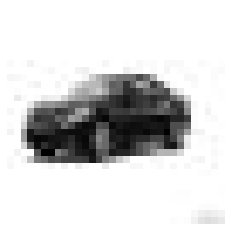

In [26]:
import glob
import random

file_list = glob.glob(test_folder + '/**/**.jpg')
img_path = random.choice(file_list)
img_cat = os.path.split(os.path.dirname(img_path))[1]
img = Image.open(img_path)
X = np.array(img)

REVERSED_IMAGE_CLASSES_MAP = dict(map(reversed, IMAGE_CLASSES_MAP.items()))

def index_from_raw_prediction(prediction):
    return min(round(prediction[0]), len(IMAGE_CLASSES) - 1)

def result_from_raw_prediction(prediction):
    return REVERSED_IMAGE_CLASSES_MAP[index_from_raw_prediction(prediction)]
    
print("Categories: ", REVERSED_IMAGE_CLASSES_MAP, "\n")

result = model.predict(process_images_array([X]))[0]

print("Raw prediction: ", result)
print("Prediction: ", result_from_raw_prediction(result))
print("Actual Category: ", img_cat)

plt.imshow(img)
plt.axis('off')

In [27]:
# procesa las imágenes con el modelo 
raw_predictions = model.predict(_x_test)

predictions = list(map(result_from_raw_prediction, raw_predictions))
actual_classes = list(map(lambda y: REVERSED_IMAGE_CLASSES_MAP[y], _y_test))

# muestra reporte de clasificación
print("\nReporte de Clasificación: ")
print(classification_report(actual_classes, predictions))

# muestra matriz de confusion
print('\nMatriz de Confusión: ')
cm = confusion_matrix(actual_classes, predictions, labels=IMAGE_CLASSES)
print(pd.DataFrame(
    cm, 
    index=['r:{:}'.format(x) for x in IMAGE_CLASSES], 
    columns=['p:{:}'.format(x) for x in IMAGE_CLASSES]
  ))


Reporte de Clasificación: 
              precision    recall  f1-score   support

         car       0.84      0.34      0.49        93
  motorcycle       0.35      0.95      0.51        58
       truck       0.89      0.58      0.70       125

    accuracy                           0.58       276
   macro avg       0.69      0.62      0.57       276
weighted avg       0.76      0.58      0.59       276


Matriz de Confusión: 
              p:car  p:motorcycle  p:truck
r:car            32            52        9
r:motorcycle      3            55        0
r:truck           3            50       72
